In [8]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Upload the api file

In [9]:
from google.colab import files

uploaded = files.upload()


Saving kaggle.json to kaggle.json


Make a directory in my drive

In [10]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [11]:
# Download the Intel Image Classification dataset
!kaggle datasets download -d puneet6060/intel-image-classification


 98% 338M/346M [00:06<00:00, 47.0MB/s]
100% 346M/346M [00:06<00:00, 59.0MB/s]


In [12]:
!unzip -q intel-image-classification.zip -d ./intel-image-classification


In [13]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
import os
from glob import glob
import cv2
import tensorflow as tf

In [16]:
from PIL import Image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetV2B2, MobileNetV2
from tensorflow.keras.optimizers import Optimizer, Adam
from tensorflow.keras.utils import load_img
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.utils import plot_model

In [17]:
train_path = '/content/intel-image-classification/seg_test/seg_test'
test_path = '/content/intel-image-classification/seg_train/seg_train'

In [18]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255,
                                  zoom_range=0.25,
                                  validation_split=0.2,
                                  width_shift_range=0.15,
                                  height_shift_range=0.15,
                                  horizontal_flip = True,
                                  vertical_flip = False,
                                  fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=128,
    subset='training',
    shuffle=True,
    class_mode="categorical",
)

val_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=128,
    class_mode="categorical",
    shuffle=False,
    subset="validation"
)

Found 2402 images belonging to 6 classes.
Found 598 images belonging to 6 classes.


In [19]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255,
                                  zoom_range=0.25,
                                  validation_split=0.2,
                                  width_shift_range=0.15,
                                  height_shift_range=0.15,
                                  horizontal_flip = True,
                                  vertical_flip = False,
                                  fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=128,
    subset='training',
    shuffle=True,
    class_mode="categorical",
)

val_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=128,
    class_mode="categorical",
    shuffle=False,
    subset="validation"
)

Found 2402 images belonging to 6 classes.
Found 598 images belonging to 6 classes.


In [20]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(150, 150),
    batch_size=128,
    shuffle=False,
    class_mode="categorical",
)

Found 14034 images belonging to 6 classes.


In [21]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes \n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes 

0 : buildings
1 : forest
2 : glacier
3 : mountain
4 : sea
5 : street


In [22]:
values = list(labels.values())

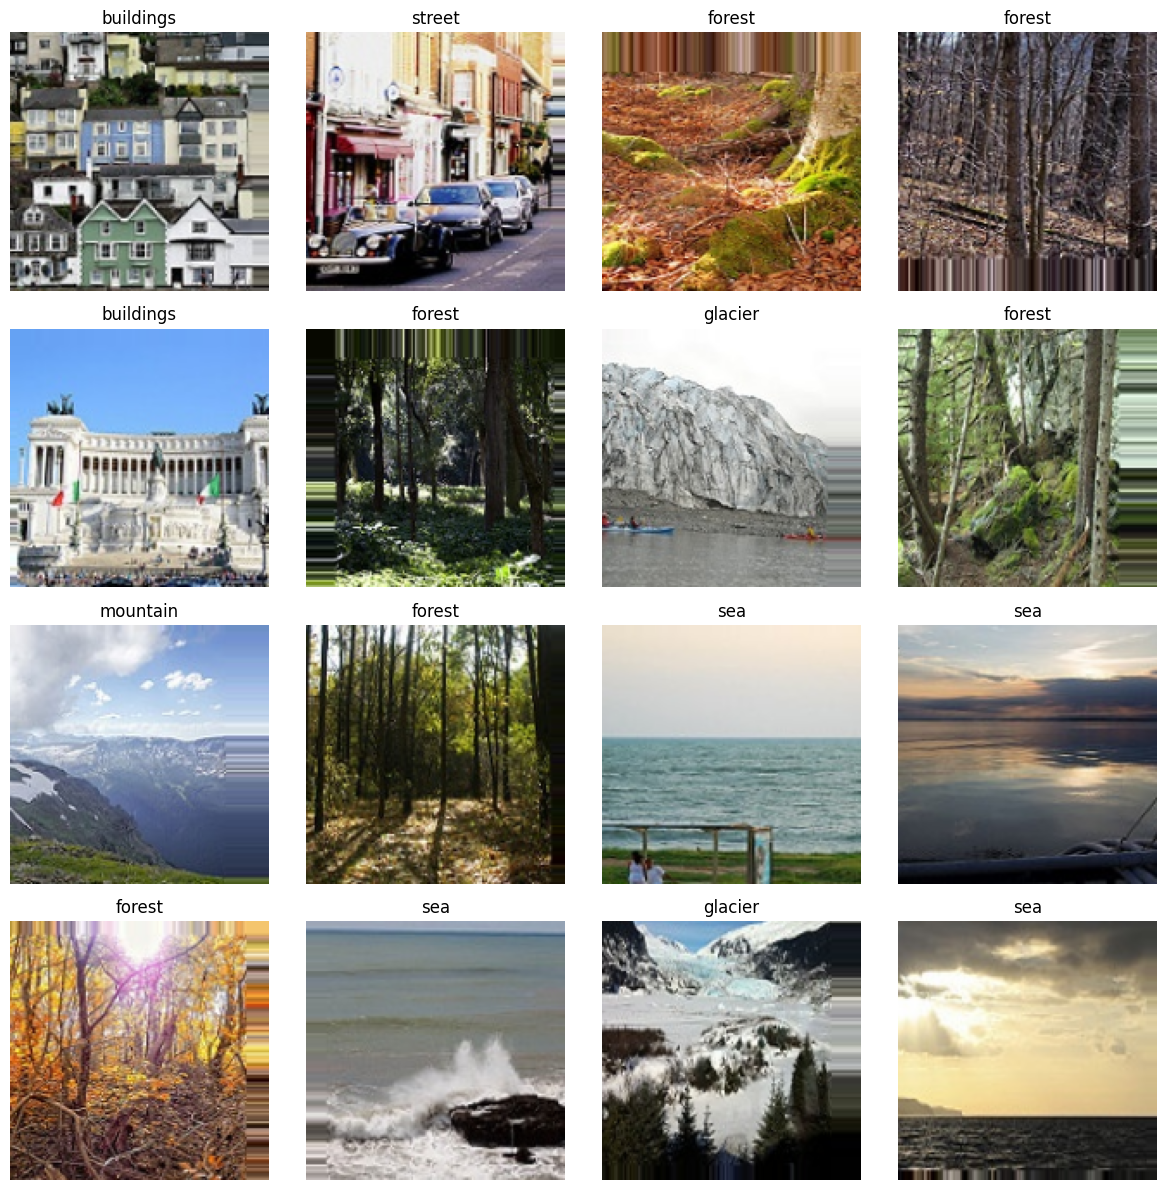

In [23]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
idx = 0

for i in range(4):
    for j in range(4):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.show()

In [24]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.ckpt',
    save_best_only=True,
    save_weights_only=True,
    monitor='val_loss'),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=4,
        restore_best_weights=True
    ),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)
]

In [25]:
def pretrained_custom_model(base_model, eps):
    pretrained_base_model = base_model(include_top = False,
                       weights = 'imagenet',
                       input_shape = (150,150,3))

    for layer in pretrained_base_model.layers:
        layer.trainable = False

    inputs = Input(shape=(150, 150, 3))
    x = pretrained_base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation = 'relu')(x)
    x = Dropout(0.2)(x)
    x =Dense(6, activation='softmax')(x)
    custom_model = Model(inputs, x)
    custom_model.summary()

    #plot_model(custom_model, show_shapes = True)

    custom_model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

    history = custom_model.fit(train_generator, validation_data = val_generator,
                                      epochs=eps,callbacks=callbacks)
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    #Plot loss and accuracy curves
    fig, ax = plt.subplots(2, 1, figsize = (8, 8))
    epochs = range(1, len(acc) + 1)
    ax[0].plot(epochs, acc, 'b--', label='Training acc')
    ax[0].plot(epochs, val_acc, 'r', label='Validation acc')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()

    ax[1].plot(epochs, loss, 'b--', label='Training loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()

    #Prediction
    pred = custom_model.predict(test_generator)
    y_test = test_generator.classes
    y_pred = np.argmax(pred, axis=1)
    model_acc = accuracy_score(y_test,y_pred)

    #Confusion matrix
    cm = confusion_matrix(y_test,y_pred)
    plt.figure(figsize = (6,6))
    sns.heatmap(cm,
            annot=True, xticklabels=values,
            yticklabels=values,
            cmap='viridis')
    plt.title('Confusion matrix of the trained model')

    print(f'The accuracy of the model is:{model_acc}')
    return custom_model, model_acc, cm

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                           

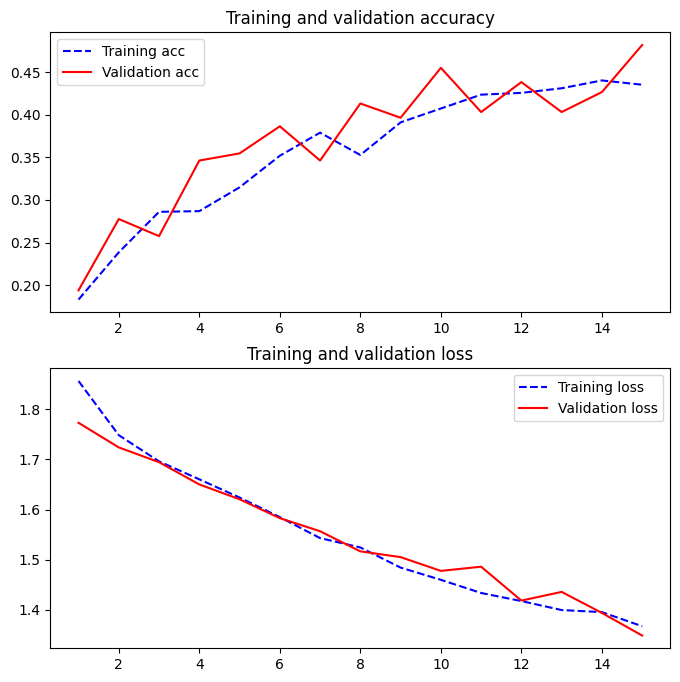

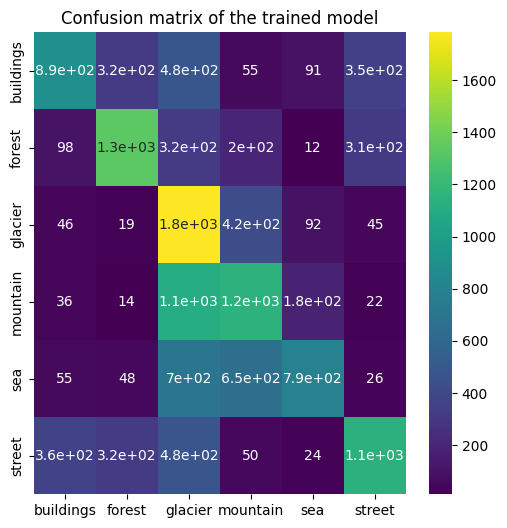

In [33]:
#https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50
resnet50_model = pretrained_custom_model(ResNet50, 15)

35839040/35839040 [==============================] - 0s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 efficientnetv2-b2 (Functio  (None, 5, 5, 1408)        8769374   
 nal)                                                            
                                                                 
 global_average_pooling2d_2  (None, 1408)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 128)               180352    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                            

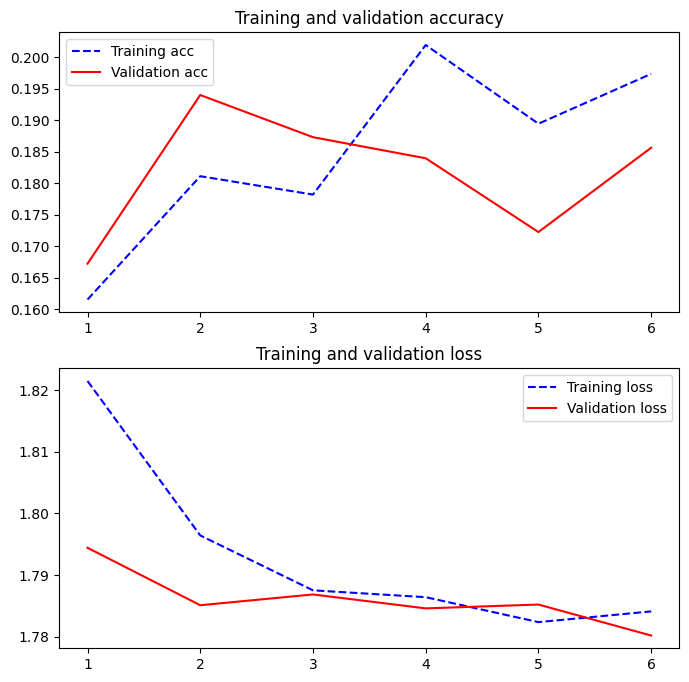

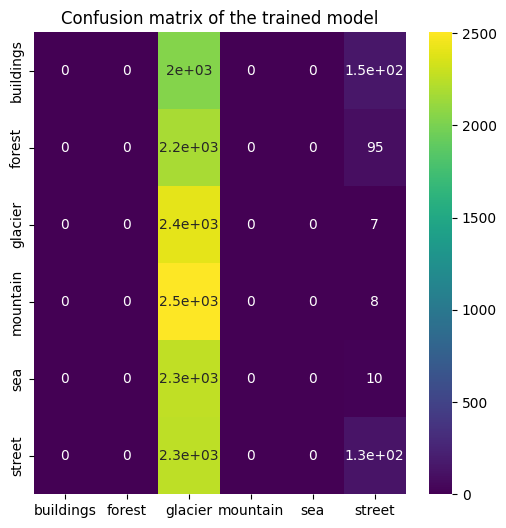

In [34]:
effnet_model = pretrained_custom_model(EfficientNetV2B2, 15)

9406464/9406464 [==============================] - 0s 0us/step
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_3  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 128)               163968    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                              

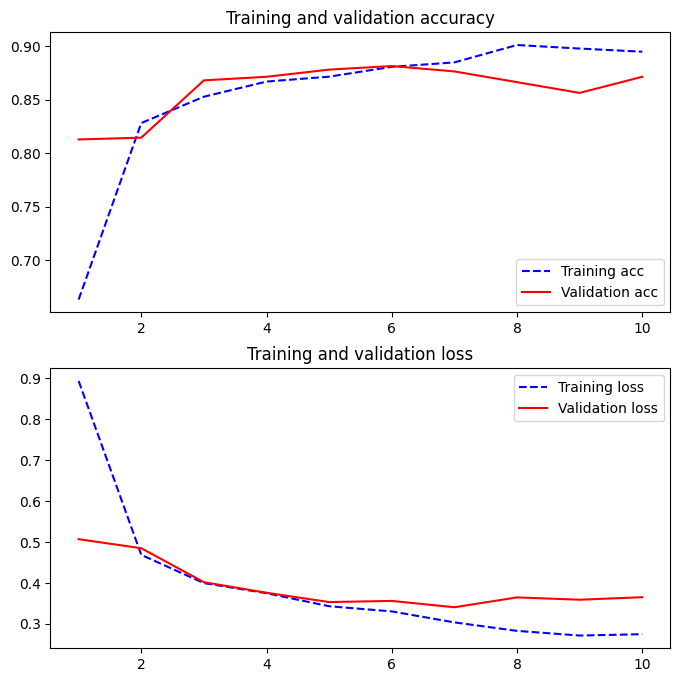

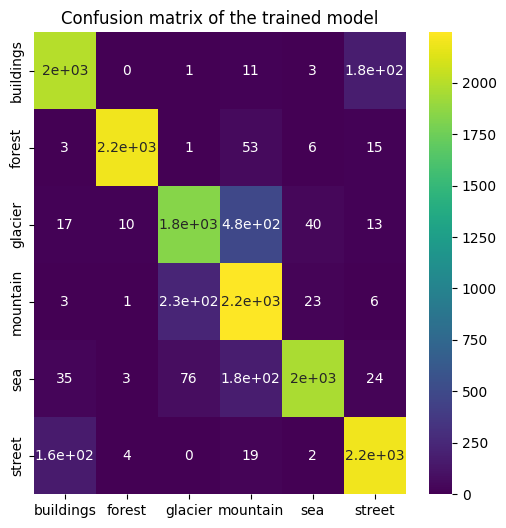

In [35]:
#https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet_v2/MobileNetV2
mobnet_model = pretrained_custom_model(MobileNetV2, 15)

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 774    

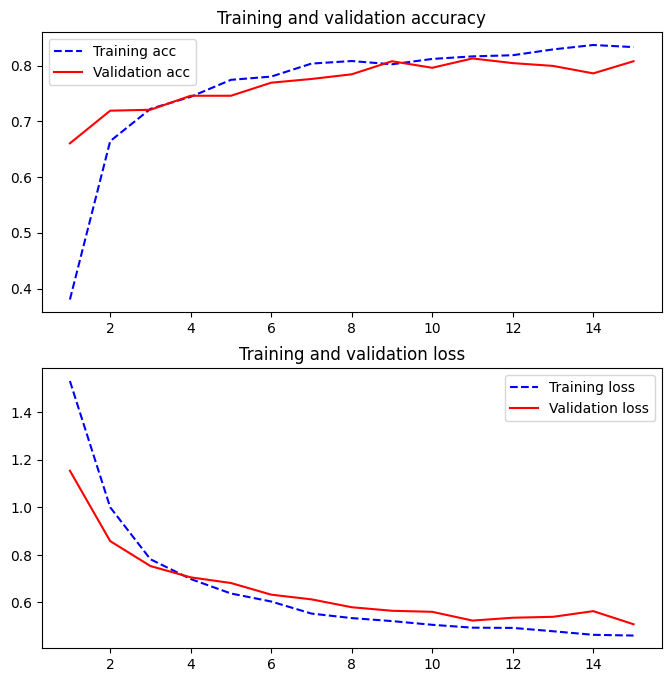

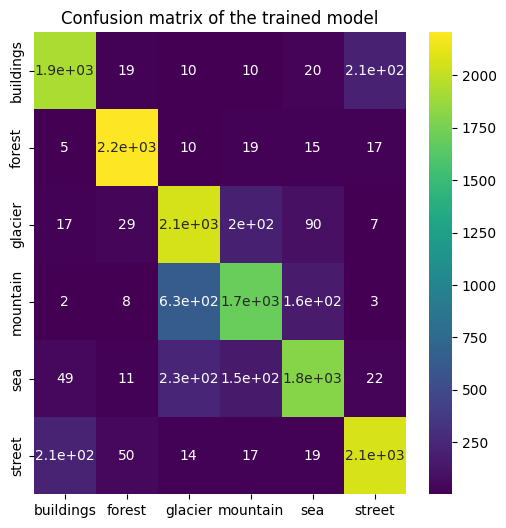

In [26]:
vgg16_model = pretrained_custom_model(VGG16, 15)

In [27]:
d  = pd.DataFrame({'Model': ['EfficientNetV2', 'ResNet50','VGG16', 'MobileNetV2'],
      'Accuracy': [effnet_model[1], resnet50_model[1],  vgg16_model[1],  mobnet_model[1]]})
d = d.set_index('Model')

NameError: ignored

In [ ]:
f, ax = plt.subplots(figsize = (7,5))
d['Accuracy'].sort_values(ascending = True).plot(ax = ax)
ax.axvline("EfficientNetV2", color="green", linestyle="dashed")
ax.axvline("ResNet50", color="green", linestyle="dashed")
ax.axvline("VGG16", color="green", linestyle="dashed")
ax.axvline("MobileNetV2", color="green", linestyle="dashed")
plt.title('Accuracy of various methods in ascending order');
